# LSTM/GRU Model Approach

In [13]:
import os
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as tm
import numpy as np
import pandas as pd

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader
from sklearn.preprocessing import MinMaxScaler

BATCH_SIZE = 32

class PowerGenModel(pl.LightningModule):
    def __init__(self, n_features=1, hidden_size=128, batch_size=256, num_layers=1, dropout=0.2, learning_rate=0.1):
        super(PowerGenModel, self).__init__()
        self.n_features = n_features
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.lr = learning_rate
        self.lstm = nn.LSTM(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        # self.gru = nn.GRU(input_size=n_features, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout, batch_first=True)
        self.mid = nn.Linear(hidden_size, n_features)
        self.linear = nn.Linear(n_features, 1)
        
        # Torchmetrics Model Statistic Functions
        self.loss = nn.MSELoss()
        self.train_acc = tm.MeanAbsoluteError()
        self.valid_acc = tm.MeanAbsoluteError()
        self.test_acc = tm.MeanAbsoluteError()

    def forward(self, input):
        # LSTM Forward Step
        lstm_out, _ = self.lstm(input)
        lstm_out = torch.sigmoid(lstm_out[:, -1])
        lstm_out = torch.sigmoid(self.mid(lstm_out))
        y_pred = self.linear(lstm_out)
        return y_pred
        # GRU Forward Step
        # gru_out, _ = self.gru(input)
        # gru_out = torch.relu(gru_out[:, -1])
        # y_pred = self.linear(gru_out)
        # return y_pred

    def configure_optimizers(self):
        # LR Step Optimizer
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=1e-5)
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
        return [optimizer], [lr_scheduler]
        # Simple optimizer
        # return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        train_acc = self.train_acc(y_hat, y)
        self.log('train_acc', train_acc, on_step=False, on_epoch=True)
        train_loss = self.loss(y_hat, y)
        self.log("train_loss", train_loss)
        return train_loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        self.valid_acc(y_hat, y)
        self.log('val_acc', self.valid_acc, on_step=False, on_epoch=True)
        val_loss = self.loss(y_hat, y)
        self.log("val_loss", val_loss)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        test_loss = self.loss(y_hat, y)
        self.log('test_loss ', test_loss)
        self.test_acc(y_hat, y)
        self.log('test_acc  ', self.test_acc)
        return test_loss

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        return self(x)

def prepareTimeSeries(data=None, rule='D', n_in = 1, n_scale=1, n_out = 1, dropnan = True):
    df = pd.DataFrame(data)
    df = df.resample(rule).mean()
    col_names = [df.columns]
    
    # Correction for Forecasting and History in days
    p_scale = 1
    if rule == 'H':
        n_scale *= 24
        p_scale = 24
    if rule == '10T':
        n_scale *= 144
        p_scale = 144
    
    # input sequence (t-n, ... t-1) -> inputs
    pd.set_option('display.max_columns', None)
    for i in range(n_in, 0, -1):
        for j in range(len(col_names)):
            df[col_names[j]+' t-'+str(i*p_scale)] = df[col_names[j]].shift(i*p_scale)
    # print(df.head())
    
    # forecast sequence (t, t+1, ... t+n) -> features
    for i in range(1, n_out+1):
        df['ActivePower t+'+str(i*n_scale)] = df['ActivePower'].shift(-i*n_scale)
    # print(df.head())

    # drop rows with NaN values
    if dropnan:
        df.dropna(inplace=True)
    return df

def create_X_Y(data=None, n_features=1, n_targets=1):
    # print(data.shape, n_features, n_targets)
    assert data.shape[1] == n_features + n_targets, f'Number of Features and Targets is not equal to the number of columns of data'
    
    X = data[:, :n_features]
    Y = data[:, n_features:n_features+n_targets]
    # print(X.shape, Y.shape)
    return X, Y

class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, seq_len=1):
        self.X = X
        self.y = y
        self.seq_len = seq_len

    def __len__(self):
        return self.X.__len__() - (self.seq_len-1)

    def __getitem__(self, index):
        return (self.X[index:index+self.seq_len], self.y[index+self.seq_len-1])

class PowerDataModule(pl.LightningDataModule): 
    def __init__(self, seq_len = 1, batch_size=32):
        super().__init__()
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.max_workers = int(os.cpu_count() * 5/6)
        self.train_workers = int(self.max_workers * 0.8)
        self.val_workers = int(self.max_workers * 0.2)
        self.test_workers = int(self.max_workers * 0.6)
        assert self.max_workers >= (
            self.train_workers + self.val_workers), f"Total number of DataLoader workers exceeds limit {self.max_workers} – Train: {self.train_workers}, Validate: {self.val_workers}"

    def prepare_data(self):
        df = pd.read_csv('./Turbine_Data.csv')
        df_sel = df[['ActivePower','AmbientTemperatue','BearingShaftTemperature','Blade1PitchAngle','Blade2PitchAngle','Blade3PitchAngle','ControlBoxTemperature',
                     'GearboxBearingTemperature','GearboxOilTemperature','GeneratorRPM','GeneratorWinding1Temperature','GeneratorWinding2Temperature','HubTemperature',
                     'MainBoxTemperature','NacellePosition','ReactivePower','RotorRPM','TurbineStatus','WTG','WindDirection','WindSpeed']]
        input_df = df_sel[['ActivePower', 'WindSpeed', 'WindDirection', 'RotorRPM', 'GeneratorRPM',
                           'GearboxBearingTemperature', 'GearboxOilTemperature', 'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature', 'TurbineStatus']]
        rng = pd.date_range('2017-12-31', periods=118224, freq='10T')
        time_df = pd.DataFrame(rng)
        input_df = input_df.fillna(0).astype(float)
        input_df = pd.concat((time_df, input_df), axis=1)
        input_df = input_df.set_index(0)
        input_df = input_df.loc['2019-10-30':]
        # Number of lags (steps back in 1day intervals) to use for models
        self.lag = 28
        # Steps in future to forecast (steps in 1day intervals)
        n_ahead = 1 # how many predictions to be made (currently only supports 1)
        n_scale = 7 # how far predictions are spaced in days
        # ratio of observations for training from total series
        train_share = 0.8
        val_share = train_share + 0.1
        # The features for the modeling
        features_final = ['ActivePower', 'WindSpeed', 'WindDirection', 'RotorRPM', 'GeneratorRPM', 'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature',]
        # Subseting only the needed columns
        ts = input_df[features_final]
        ts = prepareTimeSeries(data=ts, rule='H', n_in=self.lag, n_out=n_ahead, n_scale=n_scale, dropnan=True)
        # Scaling data between 0 and 1
        self.scaler = MinMaxScaler()
        self.scaler.fit(ts)
        ts_scaled = self.scaler.transform(ts)
        # Creating the X and Y for training, the formula is set up to assume the target Y is the left most column = target_index=0
        X, Y = create_X_Y(data=ts_scaled, n_features=len(features_final)*(self.lag+1), n_targets=n_ahead)
        
        # Spliting into train and test sets)
        self.Xtrain, self.Ytrain = X[0:int(X.shape[0] * train_share)], Y[0:int(X.shape[0] * train_share)]
        self.Xval, self.Yval = X[int(X.shape[0] * train_share):int(X.shape[0] * val_share)], Y[int(X.shape[0] * train_share):int(X.shape[0] * val_share)]
        self.Xtest, self.Ytest = X[int(X.shape[0] * val_share):], Y[int(X.shape[0] * val_share):]

    def setup(self, stage=None):
        # Assign Train/val split(s) for use in Dataloaders
        self.n_features = self.Xtrain.shape[1]
        if stage in (None, "fit"):
            # Convert Data from numpy arrays to torch Tensors
            self.train_feat = torch.from_numpy(self.Xtrain.astype(np.float32))
            self.train_targ = torch.from_numpy(self.Ytrain.astype(np.float32))
            self.val_feat = torch.from_numpy(self.Xval.astype(np.float32))
            self.val_targ = torch.from_numpy(self.Yval.astype(np.float32))
            # Convert Tensors to Datasets for dataloaders
            self.train_data = TimeseriesDataset(self.train_feat, self.train_targ, seq_len = self.seq_len)
            self.val_data = TimeseriesDataset(self.val_feat, self.val_targ, seq_len = self.seq_len)
            
        # Assign Test split(s) for use in Dataloaders
        if stage in (None, "test"):
            self.test_feat = torch.from_numpy(self.Xtest.astype(np.float32))
            self.test_targ = torch.from_numpy(self.Ytest.astype(np.float32))
            self.test_data = TimeseriesDataset(self.test_feat, self.test_targ, seq_len = self.seq_len)

    # Data loaders for training, validation, and testing data
    def train_dataloader(self):
        return DataLoader(dataset=self.train_data, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=True)

    def val_dataloader(self):
        return DataLoader(dataset=self.val_data, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=True)

    def test_dataloader(self):
        return DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=True)
    
    def predict_dataloader(self):
        return DataLoader(dataset=self.test_data, batch_size=self.batch_size, shuffle=False, num_workers=0, pin_memory=True)

In [14]:
# Requires num_workers set to 0 above
if __name__ == '__main__':
    # Data Retrieval and Processing
    dm = PowerDataModule(seq_len=1, batch_size=BATCH_SIZE)
    # Manually calling prepare and setup allows for values to be retrieved from module
    dm.prepare_data()
    dm.setup()

    # Model Instantiation
    model = PowerGenModel(n_features=dm.n_features, hidden_size=128, batch_size=BATCH_SIZE, dropout=0.3, num_layers=2)  # create new model
    model.lr = 1e-4
    # model Trainer, system agnostic
    trainer = Trainer(accelerator='auto', devices=1, min_epochs=1, max_epochs=1000, auto_lr_find=False, auto_scale_batch_size=False, default_root_dir="./",
                        precision=32, log_every_n_steps=1, check_val_every_n_epoch=1, callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=5)],)

    # Tune, fit, and test
    trainer.tune(model=model, datamodule=dm)  # tune to find best lr, batch
    trainer.fit(model=model, datamodule=dm)  # fit model to data
    trainer.test(model=model, datamodule=dm)  # test model against test data

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type              | Params
------------------------------------------------
0 | lstm      | LSTM              | 302 K 
1 | mid       | Linear            | 26.2 K
2 | linear    | Linear            | 204   
3 | loss      | MSELoss           | 0     
4 | train_acc | MeanAbsoluteError | 0     
5 | valid_acc | MeanAbsoluteError | 0     
6 | test_acc  | MeanAbsoluteError | 0     
------------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.316     Total estimated model params size (MB)


c:\Users\jdram\.conda\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\jdram\.conda\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 55: 100%|██████████| 80/80 [00:00<00:00, 151.53it/s, loss=0.052, v_num=1] 


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\jdram\.conda\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, 449.62it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       test_acc             0.19152624905109406
       test_loss           0.058187711983919144
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [15]:
import matplotlib.pyplot as plt
time = np.arange(0, len(dm.test_targ))
true_power = np.array(dm.test_targ)

pred_tens = trainer.predict(model, datamodule=dm)
pred_power = [torch.flatten(p).tolist() for sublist in pred_tens for p in sublist]
pred_power = np.array(pred_power)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\jdram\.conda\envs\pytorch\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting DataLoader 0: 100%|██████████| 9/9 [00:00<00:00, -5387.23it/s]  


# SVR Model Approach

In [16]:
from sklearn.svm import SVR
svrm = SVR(epsilon=0.1)
svrm.fit(dm.train_feat, np.ravel(dm.train_targ))
svrm_power = svrm.predict(dm.test_feat)

# LSTM/GRU to SVR Comparison

LSTM MSE:    174102.32592524932
LSTM rMSE:   417.25570807988873
LSTM MAE:    331.29505888007486
SVR MSE:     161583.15805519416
SVR rMSE:    401.9740763472119
SVR MAE:     308.5216800253223


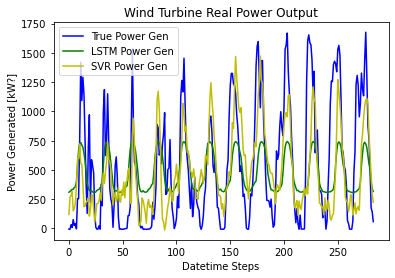

In [17]:

def invTransform(scaler, data):
        dummy = pd.DataFrame(np.zeros((len(data), scaler.n_features_in_)))
        dummy[scaler.n_features_in_-1] = data
        data = scaler.inverse_transform(dummy)
        dummy = pd.DataFrame(data, columns=dummy.columns)
        return dummy[scaler.n_features_in_-1].values

true_power = invTransform(dm.scaler, true_power)
pred_power = invTransform(dm.scaler, pred_power)
svrm_power = invTransform(dm.scaler, svrm_power)

plt.plot(time, true_power, 'b-', label='True Power Gen')
plt.plot(time, pred_power, 'g-', label='LSTM Power Gen')
plt.plot(time, svrm_power, 'y-', label='SVR Power Gen')
plt.legend()
plt.title("Wind Turbine Real Power Output")
plt.xlabel("Datetime Steps")
plt.ylabel("Power Generated [kW?]")
plt.savefig('./WindPower/plt.png')

# Metrics Display
# LSTM
lmse = np.mean((true_power - pred_power)**2)
lrmse = np.sqrt(lmse)
lmae = np.mean(np.abs(true_power - pred_power))
print('LSTM MSE:   ', lmse)
print('LSTM rMSE:  ', lrmse)
print('LSTM MAE:   ', lmae)
# SVR
smse = np.mean((true_power - svrm_power)**2)
srmse = np.sqrt(smse)
smae = np.mean(np.abs(true_power - svrm_power))
print('SVR MSE:    ', smse)
print('SVR rMSE:   ', srmse)
print('SVR MAE:    ', smae)

# SARIMAX Model Approach

In [2]:
# SETUP
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import pandas as pd

df = pd.read_csv('./Turbine_Data.csv') # slightly varies based on source
df['Datetime'] = pd.to_datetime(df['Datetime'])
df = df.resample('D', on='Datetime', origin='start').mean()

df.index = pd.DatetimeIndex(df.index).to_period('D')
df = df[['ActivePower']]

# SARIMAX: Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model
train_split = 0.9
dfl = len(df)
tra = df[0:int(dfl*train_split)].dropna()
tes = df[int(dfl*train_split):].dropna()
tr_end = tra.index[-1]
te_srt, te_end = tes.index[0], tes.index[-1]


c:\Users\jdram\.conda\envs\pytorch\lib\site-packages\pandas\core\arrays\datetimes.py:1162: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


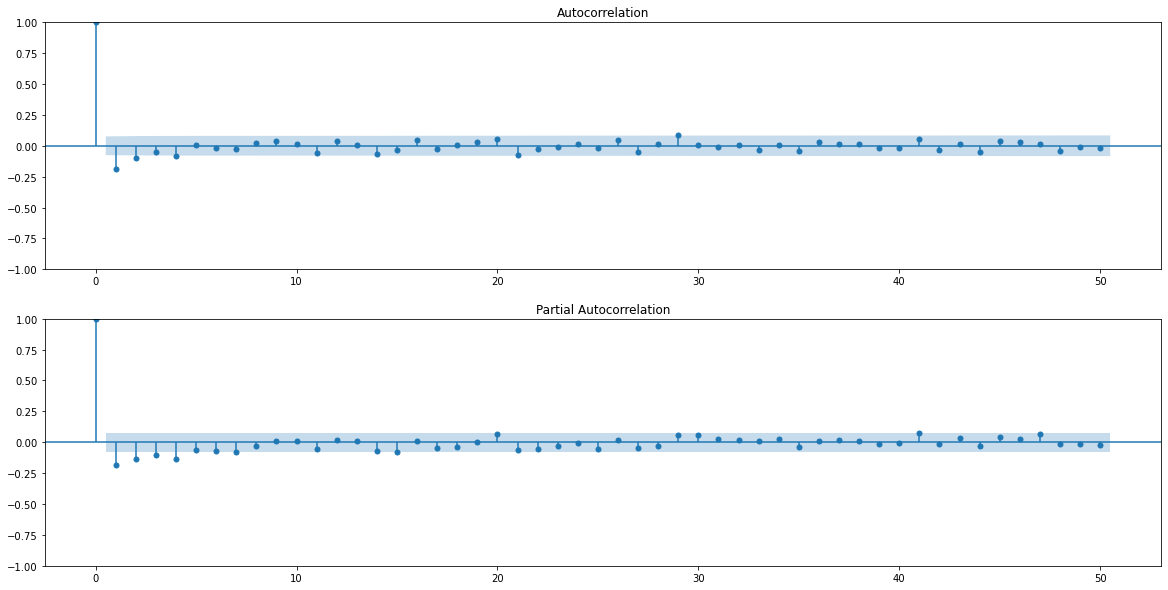

p-value:0.06632072877430333
p-value:1.6583109453630857e-20


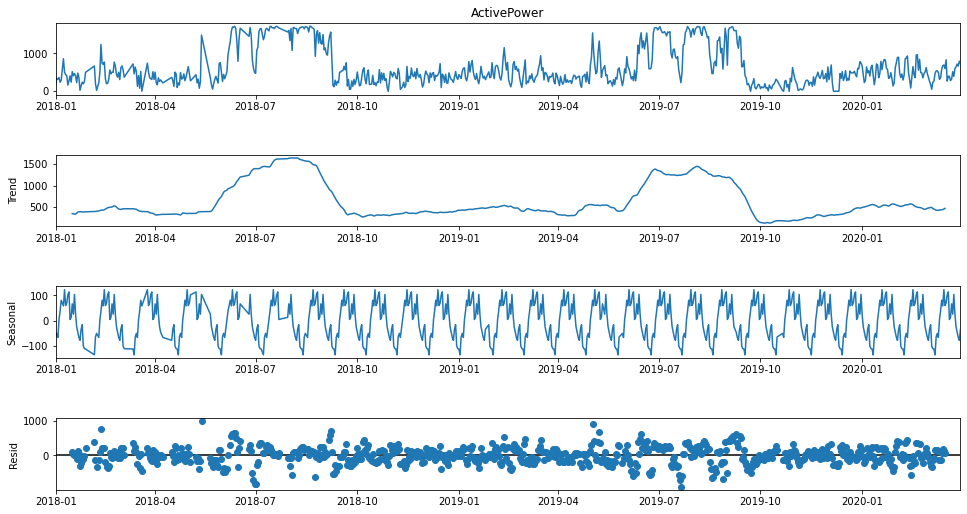

In [3]:
# Initial Statistics Exploration
import statsmodels.api as sm
import matplotlib.pyplot as plt
df.index = df.index.to_timestamp()
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig = sm.graphics.tsa.plot_acf(tra.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(
    tra.diff().dropna(), lags=50, ax=ax[1], method='ywm')
plt.show()

res = sm.tsa.adfuller(df['ActivePower'].dropna(), regression='ct')
print('p-value:{}'.format(res[1]))

res = sm.tsa.adfuller(df['ActivePower'].diff().dropna(), regression='c')
print('p-value:{}'.format(res[1]))


res = sm.tsa.seasonal_decompose(df['ActivePower'].dropna(), period=28)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()


In [20]:
# ARMA Parameter Search
resDiff = sm.tsa.arma_order_select_ic(
    tra, max_ar=30, max_ma=30, ic='aic', trend='c')
print('ARMA(p,q) =', resDiff['aic_min_order'], 'is the best.')
# Saved Result: ARMA(p,q) = (4,3) is the best.


c:\Users\jdram\.conda\envs\pytorch\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


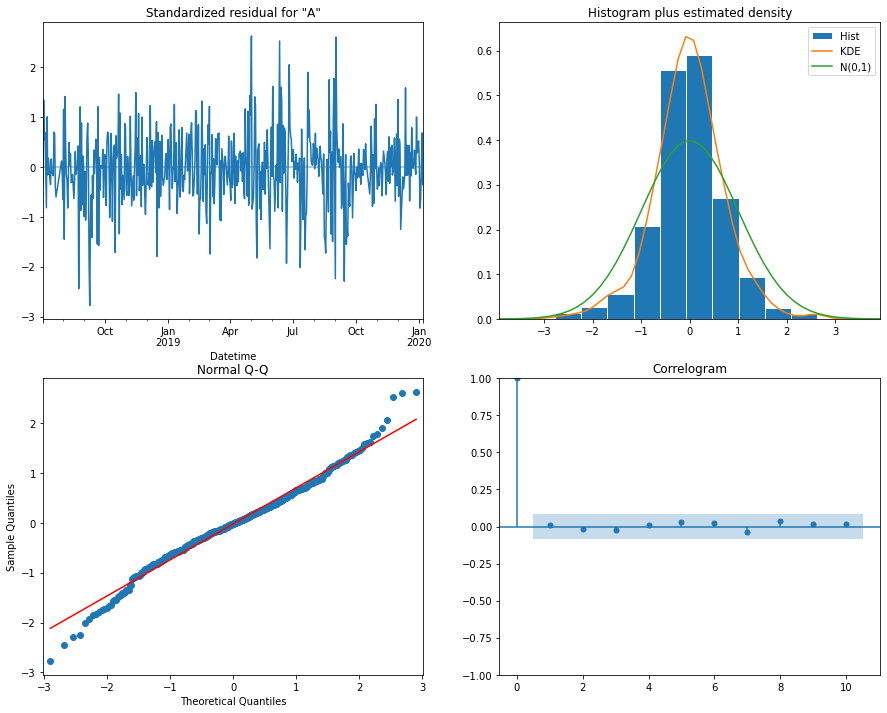

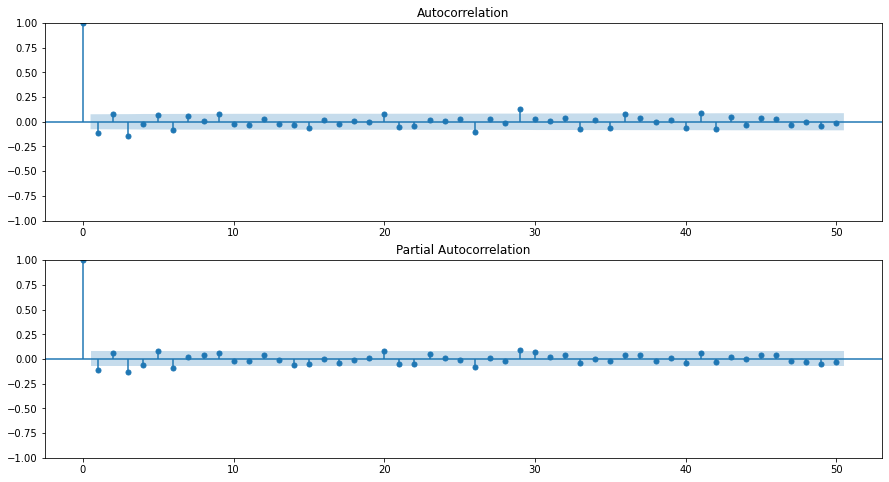

83 83
SARIMAX model MSE:67295.55976005895
SARIMAX model rMSE: 259.41387734671974
SARIMAX model MAE:205.86519446098148


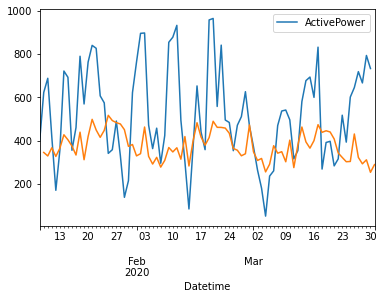

In [12]:
# SARIMAX Model
from statsmodels.tsa.statespace.sarimax import SARIMAX
p, q, d = 4,1,3
P, Q, D, s = p, q, d, 26
sarimax = SARIMAX(endog=tra, order=(p, q, d), seasonal_order=(P, Q, D, s), freq='D', 
                  enforce_stationarity=False, enforce_invertibility=False).fit()
sarimax.summary()
sarimax.plot_diagnostics(figsize=(15, 12))

res = sarimax.resid
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1], method='ywm')
plt.show()

pred = sarimax.predict(te_srt, te_end+1)[1:]
print(len(tes), len(pred))
print(f'SARIMAX model MSE:{mean_squared_error(tes, pred)}')
print(f'SARIMAX model rMSE: {np.sqrt(mean_squared_error(tes, pred))}')
print(f'SARIMAX model MAE:{mean_absolute_error(tes, pred)}')

tes.plot()
pred.plot()
plt.show()


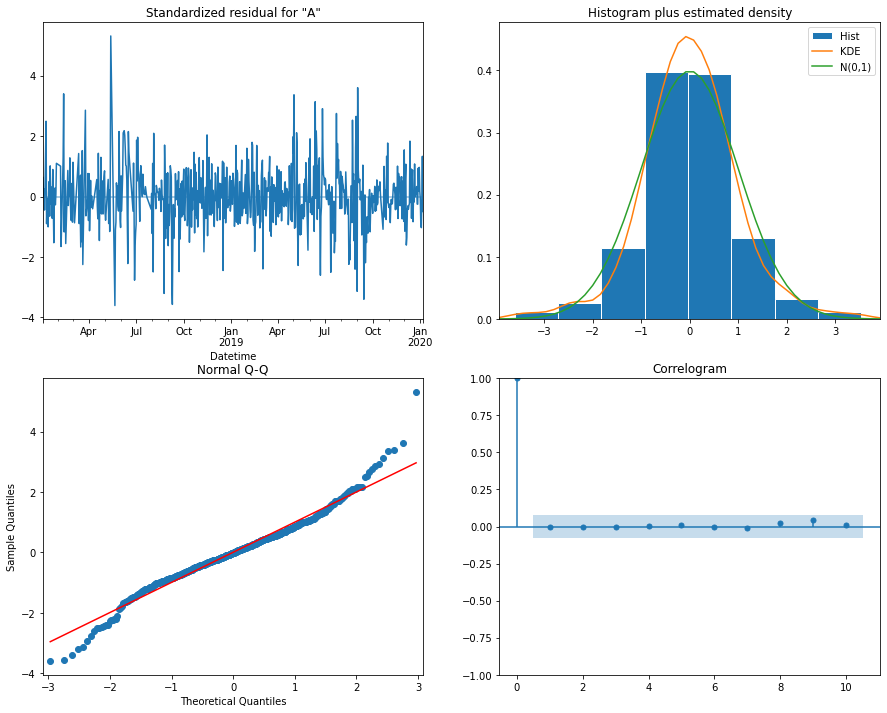

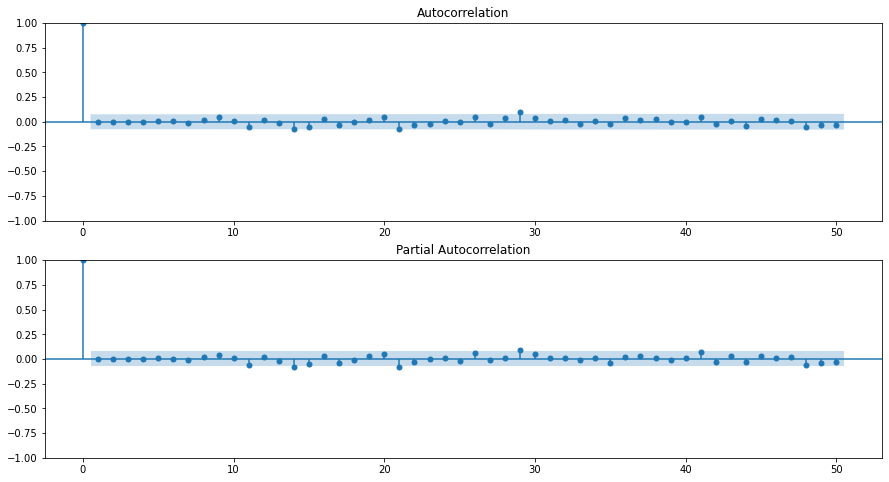

ARIMAX model MSE:47299.5160183435


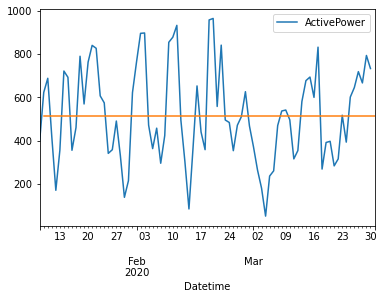

In [5]:
# ARIMA Model - data is not stationary so rather incorrect
from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(endog=tra, order=(4, 1, 3), freq='D').fit()
arima.summary()
arima.plot_diagnostics(figsize=(15, 12))

res = arima.resid
fig, ax = plt.subplots(2, 1, figsize=(15, 8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1], method='ywm')
plt.show()

apred = arima.predict(te_srt, te_end+1)[1:]
# print(len(tes), len(apred))
print('ARIMAX model MSE:{}'.format(mean_squared_error(tes, apred)))
tes.plot()
apred.plot()
plt.show()
